In [7]:
!pip install confounds
!pip install cca-zoo --upgrade

# Tutorial using confounds library with Canonical Correlation Analysis

In [8]:
#imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from confounds import Residualize
from cca_zoo.models import CCA

In [9]:
#parameters
np.random.seed(42)
#samples
n = 1000
#X features
p = 10
#Y features
q = 10
#Number of scanners
s=2

## Generate Simulated Data
We use a latent variable model to generate 2 views of data. One latent variable represents a binary confound variable such as the scanner type in a neuroimaging study. The other latent variable represents some underlying relationship between the 2 views. Notice that X and Y are multivariate and CCA will look to identify multivariate associations.

In [10]:
# Make a binary confounding variable such as scanner type/gender
confound = np.random.randint(s, size=(n, 1))

# Generate the underlying relationship of interest as a latent variable
relationship_of_interest = np.random.normal(0, 1, size=(n, 1))

# Random weights representing the effect of the confounding variable on the data
weights_cx = np.random.normal(0, 1, size=(1, p))
weights_cy = np.random.normal(0, 1, size=(1, q))

# Random weights representing the relationship of interest in the data
weights_rx = np.random.normal(0, 1, size=(1, p))
weights_ry = np.random.normal(0, 1, size=(1, q))

# Generate the 'observed' data views by projecting from the latent variables to the feature space using these weights
X = np.dot(confound, weights_cx) + np.dot(relationship_of_interest, weights_rx) + np.random.normal(0, 1, size=(n, p))
Y = np.dot(confound, weights_cy) + np.dot(relationship_of_interest, weights_cy) + np.random.normal(0, 1, size=(n, q))

## CCA using the confounded data
First we fit a CCA model to the original data. By plotting the learnt projections to the latent space, we see that the learnt association is dominated by the effect of the confounding variable (which could be for example scanner type).

Text(0.5, 0.98, 'Confounded CCA')

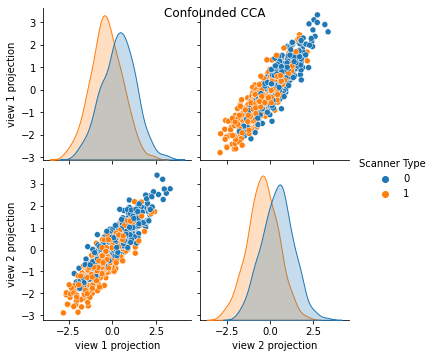

In [11]:
cca = CCA().fit((X, Y))
transformed_x, transformed_y = cca.transform((X,Y))

data = pd.DataFrame(
    {'Scanner Type': np.squeeze(confound).astype(str), 'view 1 projection': np.squeeze(transformed_x),
     'view 2 projection': np.squeeze(transformed_y)})
cca_pp = sns.pairplot(data, hue='Scanner Type')
cca_pp.fig.suptitle('Confounded CCA')

## CCA using the deconfounded data
Now we use confounds to remove the variance associated with the scanner type from **both** views. To do this we can use two instances of Residualize() - one for each view (X and Y). This time, the CCA model finds a similarly strong relationship between the two views but this association is not driven by the 'scanner type' confounding variable.

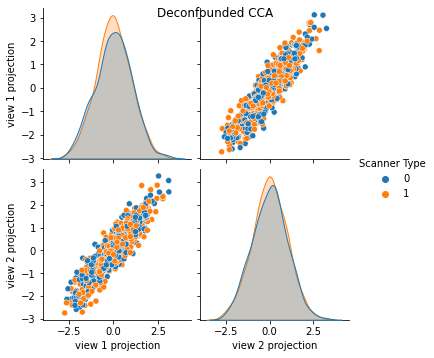

In [13]:
# We can use Residualize() to regress out the effect of the confounding variable
resid_x = Residualize()
resid_y = Residualize()
resid_x.fit(X, confound)
resid_y.fit(Y, confound)
deconf_X = resid_x.transform(X, confound)
deconf_Y = resid_y.transform(Y, confound)

# Fit a CCA to the deconfounded data
deconf_cca = CCA().fit((deconf_X, deconf_Y))
deconf_transform_x, deconf_transform_y = deconf_cca.transform((deconf_X,deconf_Y))

deconf_data = pd.DataFrame(
    {'Scanner Type': np.squeeze(confound).astype(str),
     'view 1 projection': np.squeeze(deconf_transform_x),
     'view 2 projection': np.squeeze(deconf_transform_y)})

cca_pp_deconf = sns.pairplot(deconf_data, hue='Scanner Type')
cca_pp_deconf.fig.suptitle('Deconfounded CCA')
plt.show()